In [1]:
import numpy as np
import shutil,os,glob
import xarray as xr
import pandas as pd
import datetime
from matplotlib import pyplot as plt

from parflow import Run
from parflow.tools.fs import exists, chdir, mkdir, cp, rm
from parflow import read_pfb, read_pfb_sequence, ParflowBinaryReader
from parflow.tools import hydrology as pfhyd

Definition of working dir and other paths:

In [2]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/Allada/active/inputs/Allada3D/python/"
run_dir = "/home/hectorb/PARFLOW/PROJECTS/Allada/active/inputs/Allada3D/python/run_test/"
forc_dir="/home/hectorb/PARFLOW/PROJECTS/Allada/active/inputs/Allada3D/"

# 1. Run the model

## 1.1. Load a ParFlow Input DataBase

In [3]:
allada=Run.from_definition(root_dir+'allada.pfidb')

## 1.2. Prepare input files

This step is needed to create a run directory, copy input files in there
This step may be used also to modify some parameters before running

In [11]:
# wdir = run_dir+'results_sens/'
if os.path.exists(run_dir):
     shutil.rmtree(run_dir)
os.mkdir(run_dir)

shutil.copy(forc_dir+'Xslopes_allada.pfb',run_dir+'xslope.pfb')
shutil.copy(forc_dir+'Yslopes_allada.pfb',run_dir+'yslope.pfb')
#shutil.copy(forc_dir+'allada3D_5d_R100_K5_4.press.16.pfb',run_dir+'cond_init.pfb')



allada.dist(run_dir+'xslope.pfb')
allada.dist(run_dir+'yslope.pfb')
#allada.dist(run_dir+'cond_init.pfb')


## 1.3. Run the simulation

In [12]:
allada.run(working_directory=run_dir,skip_validation=True)


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_2022_07/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Allada/active/inputs/Allada3D/python/run_test
# ParFlow database
#  - allada.pfidb
# ==============================================================================

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================



# 2. Post-processing

## 2.1. Read main output files (pressure, saturation, parameters)

In [13]:
def read_pf_outputs(wdir,date_start="2005-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])[:,0,0]
    var_dz = var_dz[::-1]
    dz = var_dz * h['dz']
    z = np.cumsum(dz) - var_dz/2 
    
    # get slopes
    slopex = read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])
    slopey = read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])
    
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y","x"), press[:,::-1,:,:]),
                    "satur": (("time","z","y","x"), satur[:,::-1,:,:])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files),freq='M'),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.x.attrs['units']='meters'    
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [23]:
ds1 = read_pf_outputs(run_dir)

{'x': 382000.0, 'y': 701000.0, 'z': 0.0, 'nx': 52, 'ny': 68, 'nz': 25, 'dx': 1000.0, 'dy': 1000.0, 'dz': 4.0, 'n_subgrids': 4, 'p': 2, 'q': 2, 'r': 1}


In [24]:
ds1

<xarray.Dataset>
Dimensions:         (time: 500, z: 25, y: 68, x: 52)
Coordinates:
  * x               (x) float64 3.82e+05 3.83e+05 3.84e+05 ... 4.32e+05 4.33e+05
  * y               (y) float64 7.01e+05 7.02e+05 7.03e+05 ... 7.67e+05 7.68e+05
  * z               (z) float64 -0.175 -0.375 -0.575 ... -87.0 -95.0 -99.5
  * time            (time) datetime64[ns] 2005-01-31 2005-02-28 ... 2046-08-31
    reference_time  datetime64[ns] 2005-01-01
Data variables:
    press           (time, z, y, x) float64 -4.191 -4.191 -4.191 ... 96.45 96.28
    satur           (time, z, y, x) float64 0.1017 0.1017 0.1017 ... 0.9 0.9 0.9
    WTD             (time, y, x) float64 32.8 32.69 32.74 ... 3.199 3.046 3.223

## 2.2. Read data

In [25]:
D = pd.read_excel('/home/hectorb/PARFLOW/PROJECTS/Allada/data/Data_Piezo-tt.xlsx',sheet_name = 'Data')
WTloc = pd.read_excel('/home/hectorb/PARFLOW/PROJECTS/Allada/data/site-piezo-meteo.xlsx',sheet_name = 'site-piezo')
WTloc.set_index('Site',inplace = True)

In [26]:
WTd = pd.DataFrame()
for i in range(13):
    WTd = pd.concat([WTd,D.iloc[:,i*3:i*3+2].set_index(D.columns[i*3]).dropna().rename_axis("date")],axis = 1)

# from https://towardsdatascience.com/the-unreasonable-effectiveness-of-method-chaining-in-pandas-15c2109e3c69
fn = lambda x: x.columns.str.replace(r" \(prof\)","") 
WTd.columns = fn(WTd)

0
1
2
3
4
5
6
7
8
9
10
11
12


/tmp/ipykernel_48725/2016681101.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  fn = lambda x: x.columns.str.replace(r" \(prof\)","")


(13514.0, 17897.0)

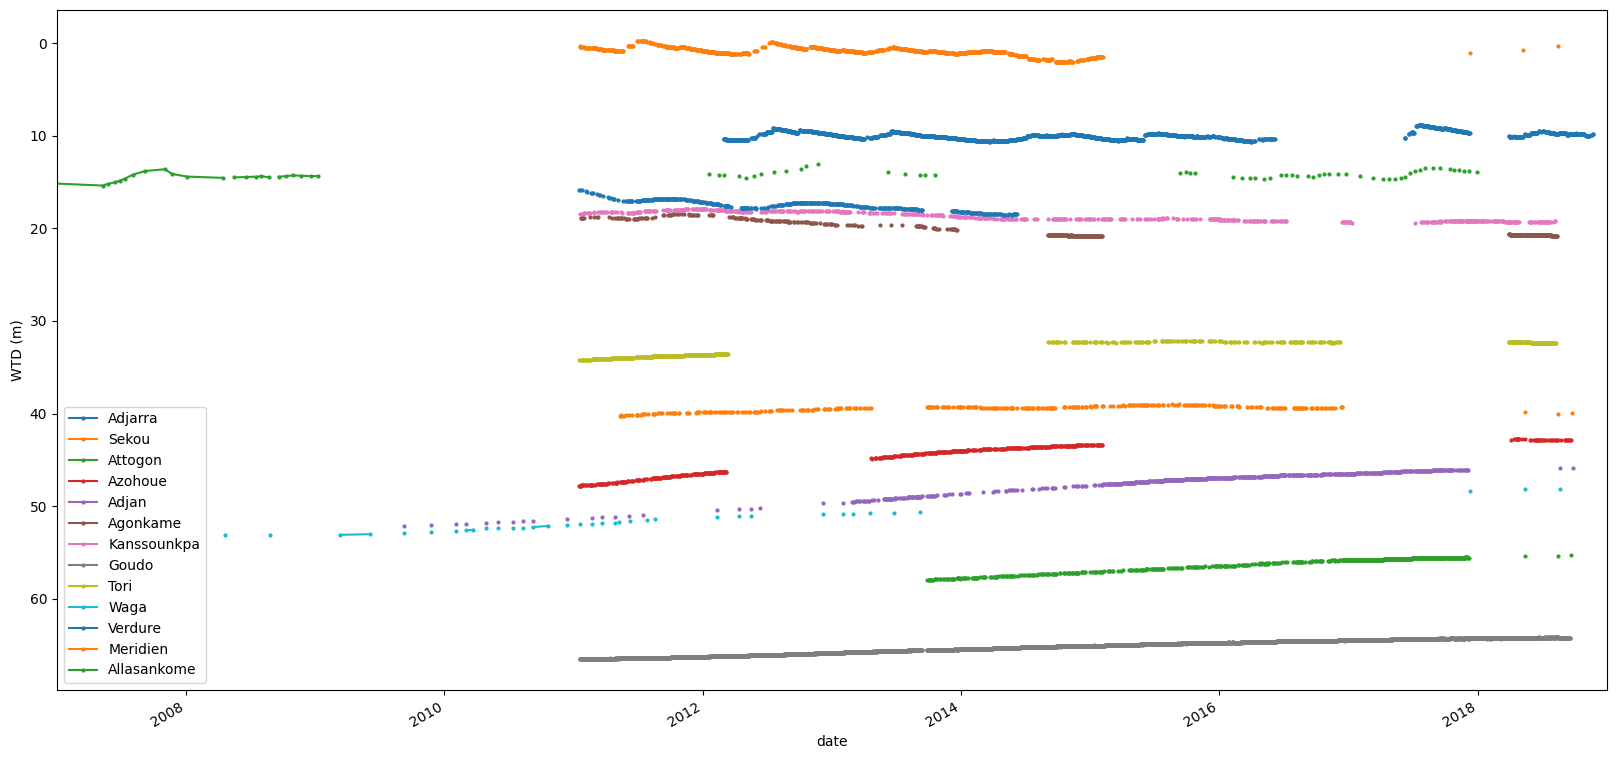

In [30]:
######## BEWARE HERE WHEN PLOTTING MULTIPLE COLUMNS OF A DD WITH NANs:
######## DEFAULT PLOT STYLE IS LINE, and only consecutive data points are therefore plotted!!!
######## WORKAROUND: USE OTHER MARKER STYLE OR PLOT EACH COLUMN INDIVIDUALLY USING DROPNA
ax = WTd.plot(figsize = [20,10],marker='o',markersize=2)
ax.invert_yaxis()
ax.set_ylabel('WTD (m)')
ax.set_xlim([datetime.datetime(2007,1,1),datetime.datetime(2019,1,1)])

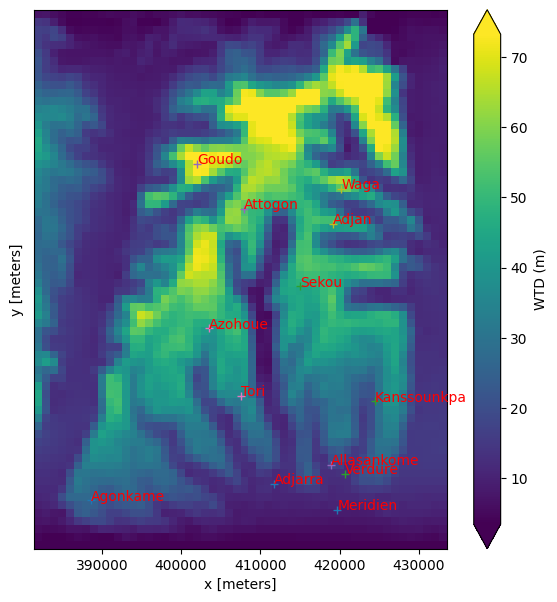

In [39]:
fig,ax = plt.subplots(1,1,figsize = [7,7])
ds1.WTD.mean(dim='time').plot(ax=ax,cmap = 'viridis',robust=True, cbar_kwargs={'label':'WTD (m)'})
for station in WTloc.Y.index:
    ax.plot(WTloc.loc[station,'X'],WTloc.loc[station,'Y'],'+','r')
    ax.text(WTloc.loc[station,'X'],WTloc.loc[station,'Y'],station,color ='r')
ax.set_title("")
ax.set_aspect('equal')

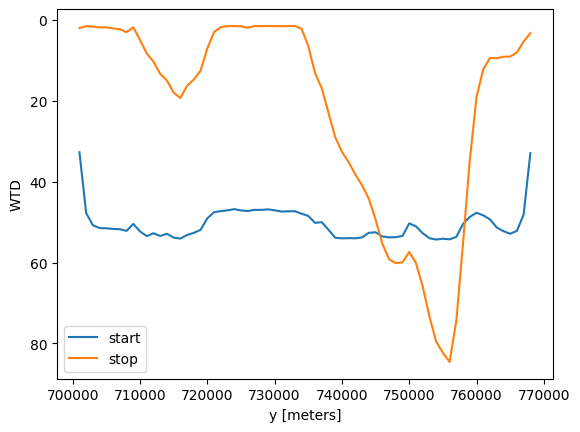

In [51]:
ds1.WTD.sel(x=410000,method='nearest').isel(time=0).plot(label='start')
ds1.WTD.sel(x=410000,method='nearest').isel(time=-1).plot(label='stop')
plt.legend()
plt.gca().set_title("")
plt.gca().invert_yaxis()

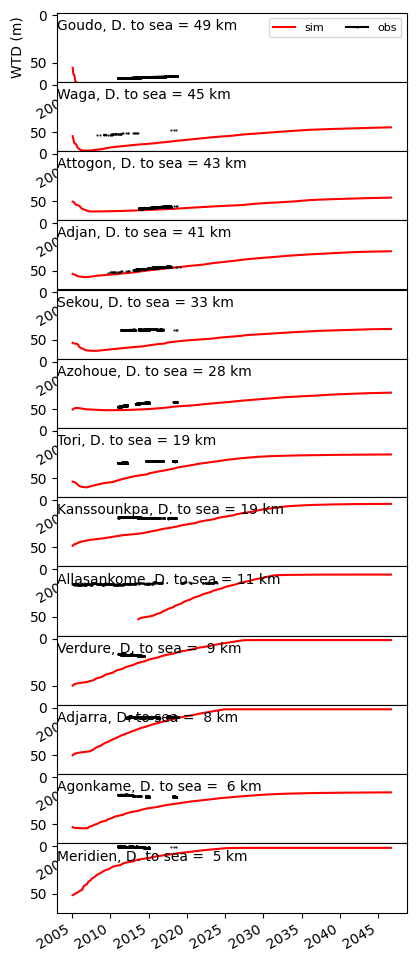

In [38]:
fig,ax = plt.subplots(WTloc.shape[0],1,figsize = [5,10])
for i,station in enumerate(WTloc.Y.sort_values(ascending = False).index):
    ds1.WTD.sel(y = WTloc.loc[station,'Y'], x = WTloc.loc[station,'X'],method = 'nearest',tolerance =500).plot(ax = ax[i],color='r')
    WTd.loc[:,station].plot(ax = ax[i],color = 'k',marker='.',markersize=1)
    #~ ax[i].legend(station)
    ax[i].set_title('')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_ylim([-3,70])
    ax[i].text(ax[i].get_xlim()[0],15,'%s, D. to sea = %2.0f km'%(station,(WTloc.loc[station,'Y']-700520)/1000)) #700520 is approximately coastline location
    ax[i].invert_yaxis()
ax[0].set_ylabel('WTD (m)')    
ax[0].legend(["sim","obs"],ncol=2,loc = 'upper right',fontsize = 8)
plt.gcf().subplots_adjust(bottom=0.05, top =0.95,left=0.2, hspace=0.001,wspace=0.001)